<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>



**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.
* Autoencoders tradicionales y sus aplicaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (sin posibilidad de extensiones)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-II-2018] 

<hr style="height:2px;border:none"/>

La tarea se divide en dos secciones:

[1.](#primero) RNN sobre texto    
[2.](#segundo) Autoencoder en MNIST  


### **Nota Importante:**  
Para esta actividad **si es que no se cuenta con GPU** se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__* . Así, podrá programar en la nube con recursos elevados y luego descargar el Jupyter Notebook y entregarlo en modo Informe. 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns
import matplotlib.cm as cm
import os   
import keras as krs
import math


from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, rmsprop
from keras.layers.core import Dense, Activation
from keras.layers import Dense, Activation
from keras import backend as bknd
from keras.datasets import cifar10
from keras import utils as np_utils
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l1,l2
import pickle
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10, mnist

In [0]:
from google.colab import drive
import pickle

drive.mount('/content/drive', force_remount=True)
DATA_PATH = "/content/drive/My Drive/Colab Tarea 3/Models/"

Mounted at /content/drive


In [0]:
def Repartir_Conjuntos(Train,Test,x,y):
  print("This function splits the framework this way:\n Train from 0% to (First parameter)%\n Test from (First parameter)% to (First+Second parameter)%\n Validation will be the rest.")
  if (0<Train<1) == False:
    print("ERROR: First parameter must be type float between 0 and 1")
    return
  if (0<Test<1) == False:
    print("ERROR: Second parameter must be type float between 0 and 1")
    return
  if (Train+Test<1) == False:
    print("ERROR: First parameter plus Second parameter can't be bigger than one")
    return
  
  largo = len(x);
  Train=int(Train*largo);
  Test = int(Test*largo + Train);
  (x_train, y_train)=x[0:Train],y[0:Train];
  (x_test, y_test)=x[Train:Test],y[Train:Test];
  (x_val, y_val)=x[Test:],y[Test:];
  return((x_train, y_train),(x_test, y_test),(x_val, y_val))

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train,x_test), axis=0);
x = x.astype('float32') / 255.
y = np.concatenate((y_train,y_test), axis=0);
[[x_train, y_train],[x_test, y_test],[x_val, y_val]]=Repartir_Conjuntos(0.5,0.3,x,y)
print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)

print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)

print("x_val's shape:   ",x_val.shape)
print("y_vals's shape:  ",y_val.shape)

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)

print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)

print("x_val's shape:   ",x_val.shape)
print("y_val's shape:   ",y_val.shape)

num_classes=10
y_train_categ = krs.utils.to_categorical(y_train, num_classes)
y_test_categ = krs.utils.to_categorical(y_test, num_classes)
y_val_categ = krs.utils.to_categorical(y_val, num_classes)

print("-----------------------------------")
print("x_train's shape      : ",x_train.shape)
print("y_train's categ shape: ",y_train_categ.shape)

print("x_test's shape      :  ",x_test.shape)
print("y_test's categ shape:  ",y_test_categ.shape)

print("x_val's shape      :   ",x_val.shape)
print("y_val's categ shape:   ",y_val_categ.shape)

This function splits the framework this way:
 Train from 0% to (First parameter)%
 Test from (First parameter)% to (First+Second parameter)%
 Validation will be the rest.
-----------------------------------
x_train's shape:  (35000, 28, 28)
y_train's shape:  (35000,)
x_test's shape:   (21000, 28, 28)
y_test's shape:   (21000,)
x_val's shape:    (14000, 28, 28)
y_vals's shape:   (14000,)
-----------------------------------
x_train's shape:  (35000, 784)
y_train's shape:  (35000,)
x_test's shape:   (21000, 784)
y_test's shape:   (21000,)
x_val's shape:    (14000, 784)
y_val's shape:    (14000,)
-----------------------------------
x_train's shape      :  (35000, 784)
y_train's categ shape:  (35000, 10)
x_test's shape      :   (21000, 784)
y_test's categ shape:   (21000, 10)
x_val's shape      :    (14000, 784)
y_val's categ shape:    (14000, 10)


### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

> a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**

In [0]:
from keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
from keras.models import Sequential
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_categ,nb_epoch=50, batch_size=25,shuffle=True, validation_data=(x_val, y_val_categ))
model.save(DATA_PATH+'T3_P2_4_a.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_46 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_47 (Dense)             (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Train on 35000 samples, validate on 14000 samples
Epoch 1/50
35000/35000 [==============================] - 10s 279us/step - loss: 0.9699 - acc: 0.6835 - val_loss: 0.4016 - val_acc: 0.8722
Epoch 2/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.3970 - acc: 0.8821 - val_loss: 0.3397 - val_acc: 0.8984
Epoch 3/50
35000/35000 [==============================] - 9s 262us/step - loss: 0.3464 - acc: 0.8993 - val_loss: 0.3130 - val_acc: 0.9095
Epoch 4/50
35000/35000 [==============================] - 9s 261us/step - loss: 0.3173 - acc: 0.9065 - val_loss: 0.2900 - val_acc: 0.9115
Epoch 5/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.2990 - acc: 0.9133 - val_loss: 0.2636 - val_acc: 0.9245
Epoch 6/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.2806 - acc: 0.9180 - val_loss: 0.2566 - val_acc: 0.9261
Epoch 7/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.2633 - acc: 0.9239 - val_loss: 0.2393 -

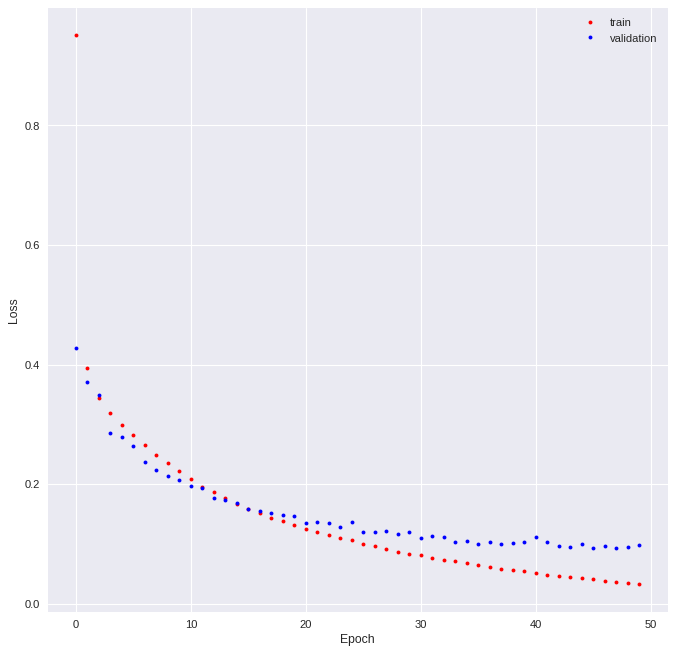

In [0]:
plt.figure(None, figsize=(10,10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'],'.r',label='train');
plt.plot(history.history['val_loss'],'.b',label='validation');
plt.ylabel('Loss');
plt.xlabel('Epoch');
plt.title('');
plt.legend();

> b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.


In [1]:
from keras.datasets import mnist
... ## Load and preprocess MNIST as usual  ??

autoencoder1 = load_model(DATA_PATH+'T3_P2_4_a.h5')
model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(784,)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error', metrics=['accuracy'])
history1 = model.fit(x_train, y_train_categ, nb_epoch=50, batch_size=25,shuffle=True, validation_data=(x_val, y_val_categ))

autoencoder1.save(DATA_PATH+'P24_autoencoder_layer1.h5')
encoder1.save(DATA_PATH+'P24_encoder_layer1.h5')

...###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
history1 = autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save(DATA_PATH+'P24_autoencoder_layer2.h5')
encoder2.save(DATA_PATH+'P24_encoder_layer2.h5')
...#FINE TUNNING

from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')

Using TensorFlow backend.


NameError: ignored

> c) Repita usando funciones de **activación *tanh*. Comente**

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.